# 0. Test Notebook 

This Notebook should help understanding the angle definition according to the order of the RVIP

In [ ]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and some other standard libs to keep this cell clean
# local imports
from src.utils.Notebook_imports import *
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Preprocess import get_ip_from_mask_3d
from src.utils.EvaluationHelper import get_ip_from_rvip_mask_3d
from src.utils.EvaluationHelper import get_angle2x, calc_distances, calc_angles2x,calc_mean_angle_diff,calc_dist_files
from src.utils.EvaluationHelper import get_angles_as_df, get_dist_as_df

# import external libs
import os, glob
import cv2
import pandas as pd
import numpy as np
import SimpleITK as sitk
from ipyfilechooser import FileChooser


In [2]:
sorting_lambda = lambda x: int(os.path.basename(x).split('_')[0].split('patient')[1])
sorting_lambda_frame = lambda x: (int(os.path.basename(x).split('_')[0].split('patient')[1]), int(os.path.basename(x).split('_')[1].split('frame')[1]))
sorting_lambda_frame_orig = lambda x: (int(os.path.basename(x).split('_')[0].split('patient')[1]), int(os.path.basename(x).split('_')[1].split('frame')[1].split('.')[0]))

# 1. Select an experiment

In [6]:
exp_chooser=FileChooser(os.getcwd())
display(exp_chooser)

FileChooser(path='/mnt/ssd/git/wft21_septum_landmark_detection', filename='', title='HTML(value='', layout=Lay…

# 2. Load GT/predictions and original masks

In [7]:
# load all necessary file names
data_root = '/mnt/ssd/data/acdc/wft2021/rvip'
path_to_exp = exp_chooser.selected
# this will collect the predictions within the 4 cv subfolders
exp_path = os.path.join(path_to_exp, '*/*/')
io_files = sorted(glob.glob(os.path.join(data_root, 'io/', '*rvip.nrrd')), key=sorting_lambda_frame)
pred_files = sorted(glob.glob(os.path.join(exp_path, 'pred', '*msk.nrrd')), key=sorting_lambda)
gt_files = sorted(glob.glob(os.path.join(exp_path, 'gt', '*msk.nrrd')), key=sorting_lambda)
cmr_files = sorted(glob.glob(os.path.join(exp_path, 'pred', '*cmr.nrrd')), key=sorting_lambda)
print('io files: ',len(io_files))
print('pred fies: ',len(pred_files))
print('gt files: ',len(gt_files))
print('cmr files: ',len(cmr_files))

#  original masks
orig_msk_files = sorted(glob.glob(os.path.join(data_root,'original','*/*frame*gt.nii.gz')), key=sorting_lambda_frame)
print('original msk files: ',len(orig_msk_files))
# original cmr
orig_cmr_files = sorted(glob.glob(os.path.join(data_root, 'original' ,'*/*frame[0-9][0-9].nii.gz')), key=sorting_lambda_frame_orig)
print('original cmr files: ',len(orig_cmr_files))


io files:  200
pred fies:  200
gt files:  200
cmr files:  200
original msk files:  200
original cmr files:  200


# 3. Describe the original acdc dataset

In [8]:
# for pathology specific filtering we can use this acdc dataframe
from src.data.Dataset import get_acdc_dataset_as_df
df = get_acdc_dataset_as_df(os.path.join(data_root, 'original'))
df = df.loc[df['phase'].isin(['ed', 'es'])]
df.reset_index(inplace=True, drop=True)
df

,index,pathology,patient,files,phase
0,1,DCM,patient001,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,ed
1,3,DCM,patient001,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,es
2,1,DCM,patient002,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,ed
3,3,DCM,patient002,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,es
4,1,DCM,patient003,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,ed
...,...,...,...,...,...
195,3,RV,patient098,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,es
196,1,RV,patient099,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,ed
197,3,RV,patient099,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,es
198,1,RV,patient100,/mnt/ssd/data/acdc/wft2021/rvip/original/patie...,ed


# 4. Inspect/plot single patients + labels from all file lists

In [11]:
# inspect single patients + labels from all file lists
@interact
def show_rvip_msk(i = (0,199,1), dataset=['gt', 'io', 'pred', 'msk', 'msk_rvip'], use_mean_rvips=False):
    global temp_msk
    
    ismsk=False
    
    if dataset == 'gt':
        temp_data = gt_files
    if dataset == 'io':
        temp_data = io_files
    if dataset == 'pred':
        temp_data = pred_files
    if dataset in ['msk', 'msk_rvip']:
        temp_data = orig_msk_files
        ismsk=True
        
    temp_msk = sitk.GetArrayFromImage(sitk.ReadImage(temp_data[i]))
    temp_cmr = sitk.GetArrayFromImage(sitk.ReadImage(orig_cmr_files[i]))
    print(temp_msk.shape)
    print(temp_cmr.shape)
    if ismsk: # mask of contours
        ant, inf = get_ip_from_mask_3d(temp_msk, keepdim=True, rev=True)
    else: # mask with rvips
        ant, inf = get_ip_from_rvip_mask_3d(temp_msk, keepdim=True)
    print('ants: ', ant)
    print('infs: ', inf)
    angles = calc_angles2x(temp_msk, ismsk=ismsk, usemeanips=use_mean_rvips)
    print('angles: ', angles)
    if dataset == 'msk_rvip':
        temp_msk = np.zeros(temp_msk.shape, np.uint8)
        for z in range(temp_msk.shape[0]):
            if ant[z] is not None:
                s= 3 # define an IP size, otherwise we cant see anything in this plot
                temp_msk[z, ant[z][0]-s:ant[z][0]+s, ant[z][1]-s: ant[z][1]+s] = 1
                temp_msk[z, inf[z][0]-s:inf[z][0]+s, inf[z][1]-s: inf[z][1]+s] = 2
    show_2D_or_3D(temp_cmr, temp_msk)
    

interactive(children=(IntSlider(value=99, description='i', max=199), Dropdown(description='dataset', options=(…

# 5. RVIP mask to IPs

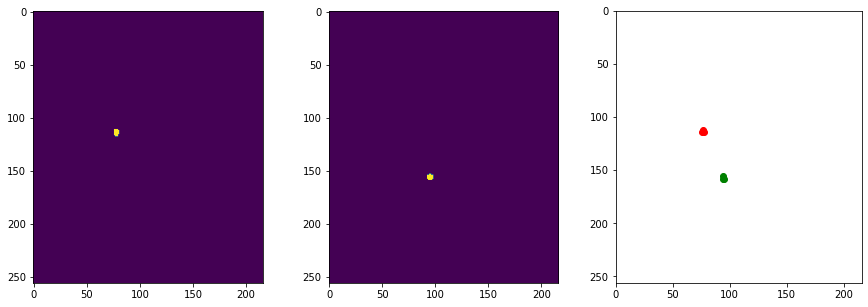

In [12]:
# define a temp mask for reading rvip mask purpose
temp =sitk.GetArrayFromImage(sitk.ReadImage(pred_files[0]))
nda_2d = temp[1]

ant, inf = get_ip_from_rvip_mask_3d(temp)
fig, ax = plt.subplots(1,3, figsize=(15,5))
# understand which point is anterior and inferior - be careful imshow inverts the y-axis !!!
ax[0].imshow(nda_2d==1) # anterior
ax[1].imshow(nda_2d==2) # inferior
ax[2].scatter(x=list(zip(*ant))[1], y=list(zip(*ant))[0], color='red') # anterior/upper
ax[2].scatter(x=list(zip(*inf))[1], y=list(zip(*inf))[0], color='green')
ax[2].set_ylim((0,nda_2d.shape[0]))
ax[2].set_xlim((0,nda_2d.shape[1]))
ax[2].invert_yaxis()

# 6. LV,MYO,RV mask to IPs

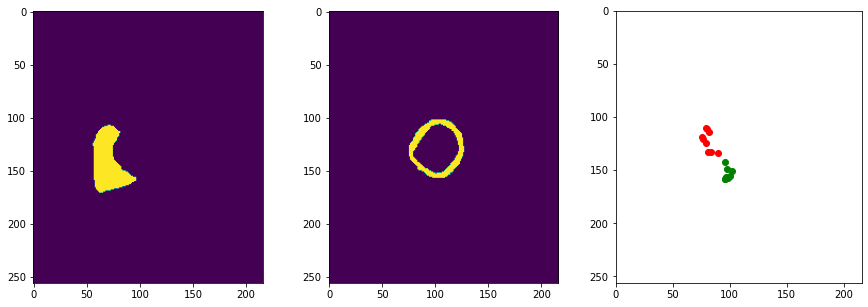

In [13]:
# define a temp mask for the mask2rvip methods purpose
temp =sitk.GetArrayFromImage(sitk.ReadImage(orig_msk_files[0]))
nda_2d = temp[1]

ant, inf = get_ip_from_mask_3d(temp, rev=True)
fig, ax = plt.subplots(1,3, figsize=(15,5))
# understand which point is anterior and inferior - be careful imshow inverts the y-axis !!!
ax[0].imshow(nda_2d==1) # anterior
ax[1].imshow(nda_2d==2) # inferior
ax[2].scatter(x=list(zip(*ant))[1], y=list(zip(*ant))[0], color='red') # anterior/upper
ax[2].scatter(x=list(zip(*inf))[1], y=list(zip(*inf))[0], color='green')
ax[2].set_ylim((0,nda_2d.shape[0]))
ax[2].set_xlim((0,nda_2d.shape[1]))
ax[2].invert_yaxis() # <--- keep that in mind!

# 7. Visualise the definition between the IPs and the septum angle

In [14]:
@interact
def test_angles(ant_x=(0,200), ant_y=(0,200), inf_x=(0,200), inf_y=(0,200)):
    # we work with y,x tuples
    # we calculate the clock-wise angle between the x-axis and the connceted IPs
    # the angle function expects first the anterior and than the inferior IP
    ant, inf = (ant_y,ant_x),(inf_y,inf_x)
    print(ant,inf)
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.scatter(x=ant_x, y=ant_y, color='red') # anterior/upper for inverted axis
    ax.scatter(x=inf_x, y=inf_y, color='green')
    
    ax.plot([ant_x, inf_x], [ant_y,inf_y])
    ax.set_ylim(0,200)
    ax.set_xlim(0,200)
    ax.invert_yaxis()
    print(get_angle2x(ant,inf))

interactive(children=(IntSlider(value=100, description='ant_x', max=200), IntSlider(value=100, description='an…

# 8. Interactive angle calculations

In [17]:
# columns=['angle_diff', 'gt_angle', 'gt_angle_sd', 'pred_angle', 'pred_angle_sd']
# this should also work with io, as angles are independent from the spacing (as long as it is always square)
@interact
def calc_angles_interact(i=range(len(gt_files)), isgtmsk=False,ispredmsk=True,  usemeanips=False):
    gt_f = gt_files[i]
    pred_f = orig_msk_files[i]
    angle_diff, gt_angle, gt_angle_sd, pred_angle, pred_angle_sd = calc_mean_angle_diff(gt_f, pred_f, isgtmsk=isgtmsk,ispredmsk=ispredmsk, usemeanips=usemeanips)
    print('angle_diff {} gt_angle {} gt_angle_sd {} pred_angle {} pred_angle_sd {}'.format(angle_diff, gt_angle, gt_angle_sd, pred_angle, pred_angle_sd))
    return 

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [20]:
# columns=['ant_m', 'ant_sd', 'inf_m', 'inf_sd']
# note:
@interact
def calc_distances_interact(i=range(len(gt_files)), physical=False):
    gt_f = gt_files[i]
    pred_f = orig_msk_files[i]
    return calc_dist_files(gt_f, pred_f, gtismsk=False, predismsk=True, physical=physical)

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

# 9. Initial steps for the eval dataframe creation

Recent steps are in src/models/evaluate_cv.py

In [23]:
# prepare some instructions
files_ = [pred_files, io_files, orig_msk_files]
ismsks = [False, False, True]
suffixes = ['pred', 'io', 'orig_msk']
use_the_mean_rvip = True
# create a df 200 x 15 with all angles
dfs = [get_angles_as_df(gt_files, f_, f2ismsk=b, suffix=s, meanips=use_the_mean_rvip) for f_, b, s in zip(files_, ismsks, suffixes)]
df_angles = pd.concat(dfs, axis=1)
# create a df 200 x 12 with all distances
dfs = [get_dist_as_df(gt_files, f_, f2ismsk=b, suffix=s, meanips=use_the_mean_rvip) for f_, b, s in zip(files_, ismsks, suffixes)]
df_dists = pd.concat(dfs, axis=1)
# combine angles and distances --> 200,27
df_eval = pd.concat([df_angles, df_dists], axis=1)

In [24]:
# extend the dataframe by patient id, phase and pathology --> 200, 33
df_eval['pred_files'], df_eval['io_files'], df_eval['orig_msk_files'] = pred_files, io_files, orig_msk_files
df_eval['patient'] = df_eval['pred_files'].map(lambda x : os.path.basename(x).split('_')[0])
df_eval['phase'] = df_eval['pred_files'].map(lambda x : os.path.basename(x).split('_')[1])
df_eval['pathology'] = df['pathology']
df_eval = df_eval.loc[:,~df_eval.columns.duplicated()]
df_eval.shape

(200, 29)

In [25]:
# check for Nan
df_eval.isnull().sum().sum()
df_eval[df_eval.isna().any(axis=1)]

,angle_diff_pred,gt_angle,gt_angle_sd,pred_angle,pred_angle_sd,angle_diff_io,io_angle,io_angle_sd,angle_diff_orig_msk,orig_msk_angle,...,ant_dist_orig_msk,ant_dist_sd_orig_msk,inf_dist_orig_msk,inf_dis_sd_orig_msk,pred_files,io_files,orig_msk_files,patient,phase,pathology


In [33]:
df_eval.to_csv(os.path.join(path_to_exp,'df_eval.csv'), index=False)

<AxesSubplot:title={'center':'orig_msk'}>

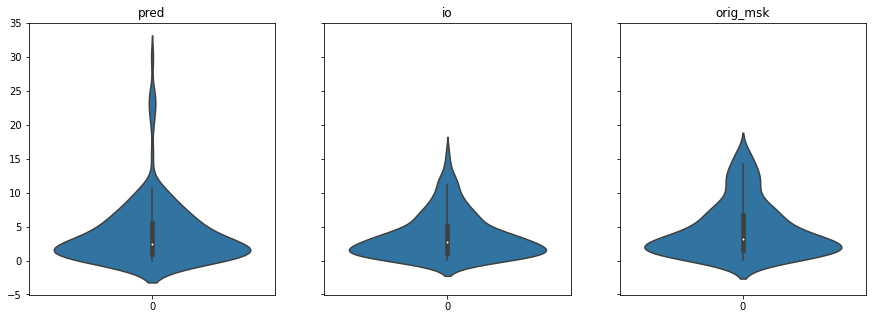

In [34]:
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)
_ = [axs[i].set_title(suffixes[i]) for i in range(len(suffixes))]
sb.violinplot(data=df_eval['angle_diff_pred'], ax=axs[0])
sb.violinplot(data=df_eval['angle_diff_io'], ax=axs[1])
sb.violinplot(data=df_eval['angle_diff_orig_msk'], ax=axs[2])

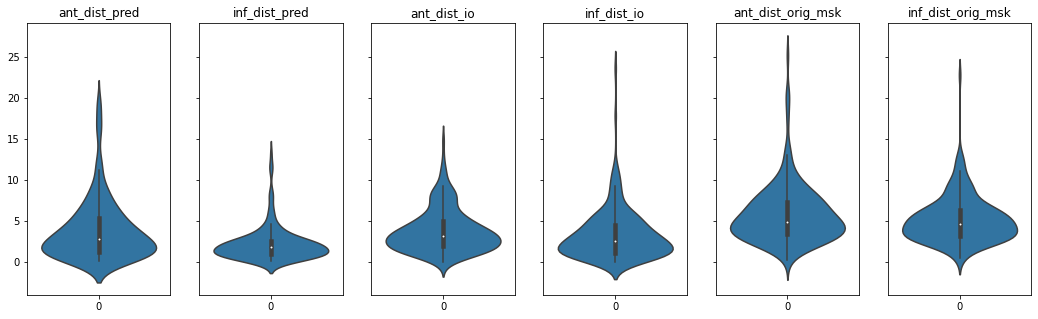

In [35]:
# anterior and inferior mean distances towards the gt/io/msk2rvip
cols = ['ant_dist_pred','inf_dist_pred','ant_dist_io','inf_dist_io','ant_dist_orig_msk', 'inf_dist_orig_msk']
fig, axs = plt.subplots(1,len(cols), figsize=(len(cols)*3,5), sharey=True)
_ = [axs[i].set_title(cols[i]) for i in range(len(cols))]
_ = [sb.violinplot(data=df_eval[cols[i]], ax=axs[i]) for i in range(len(cols))]

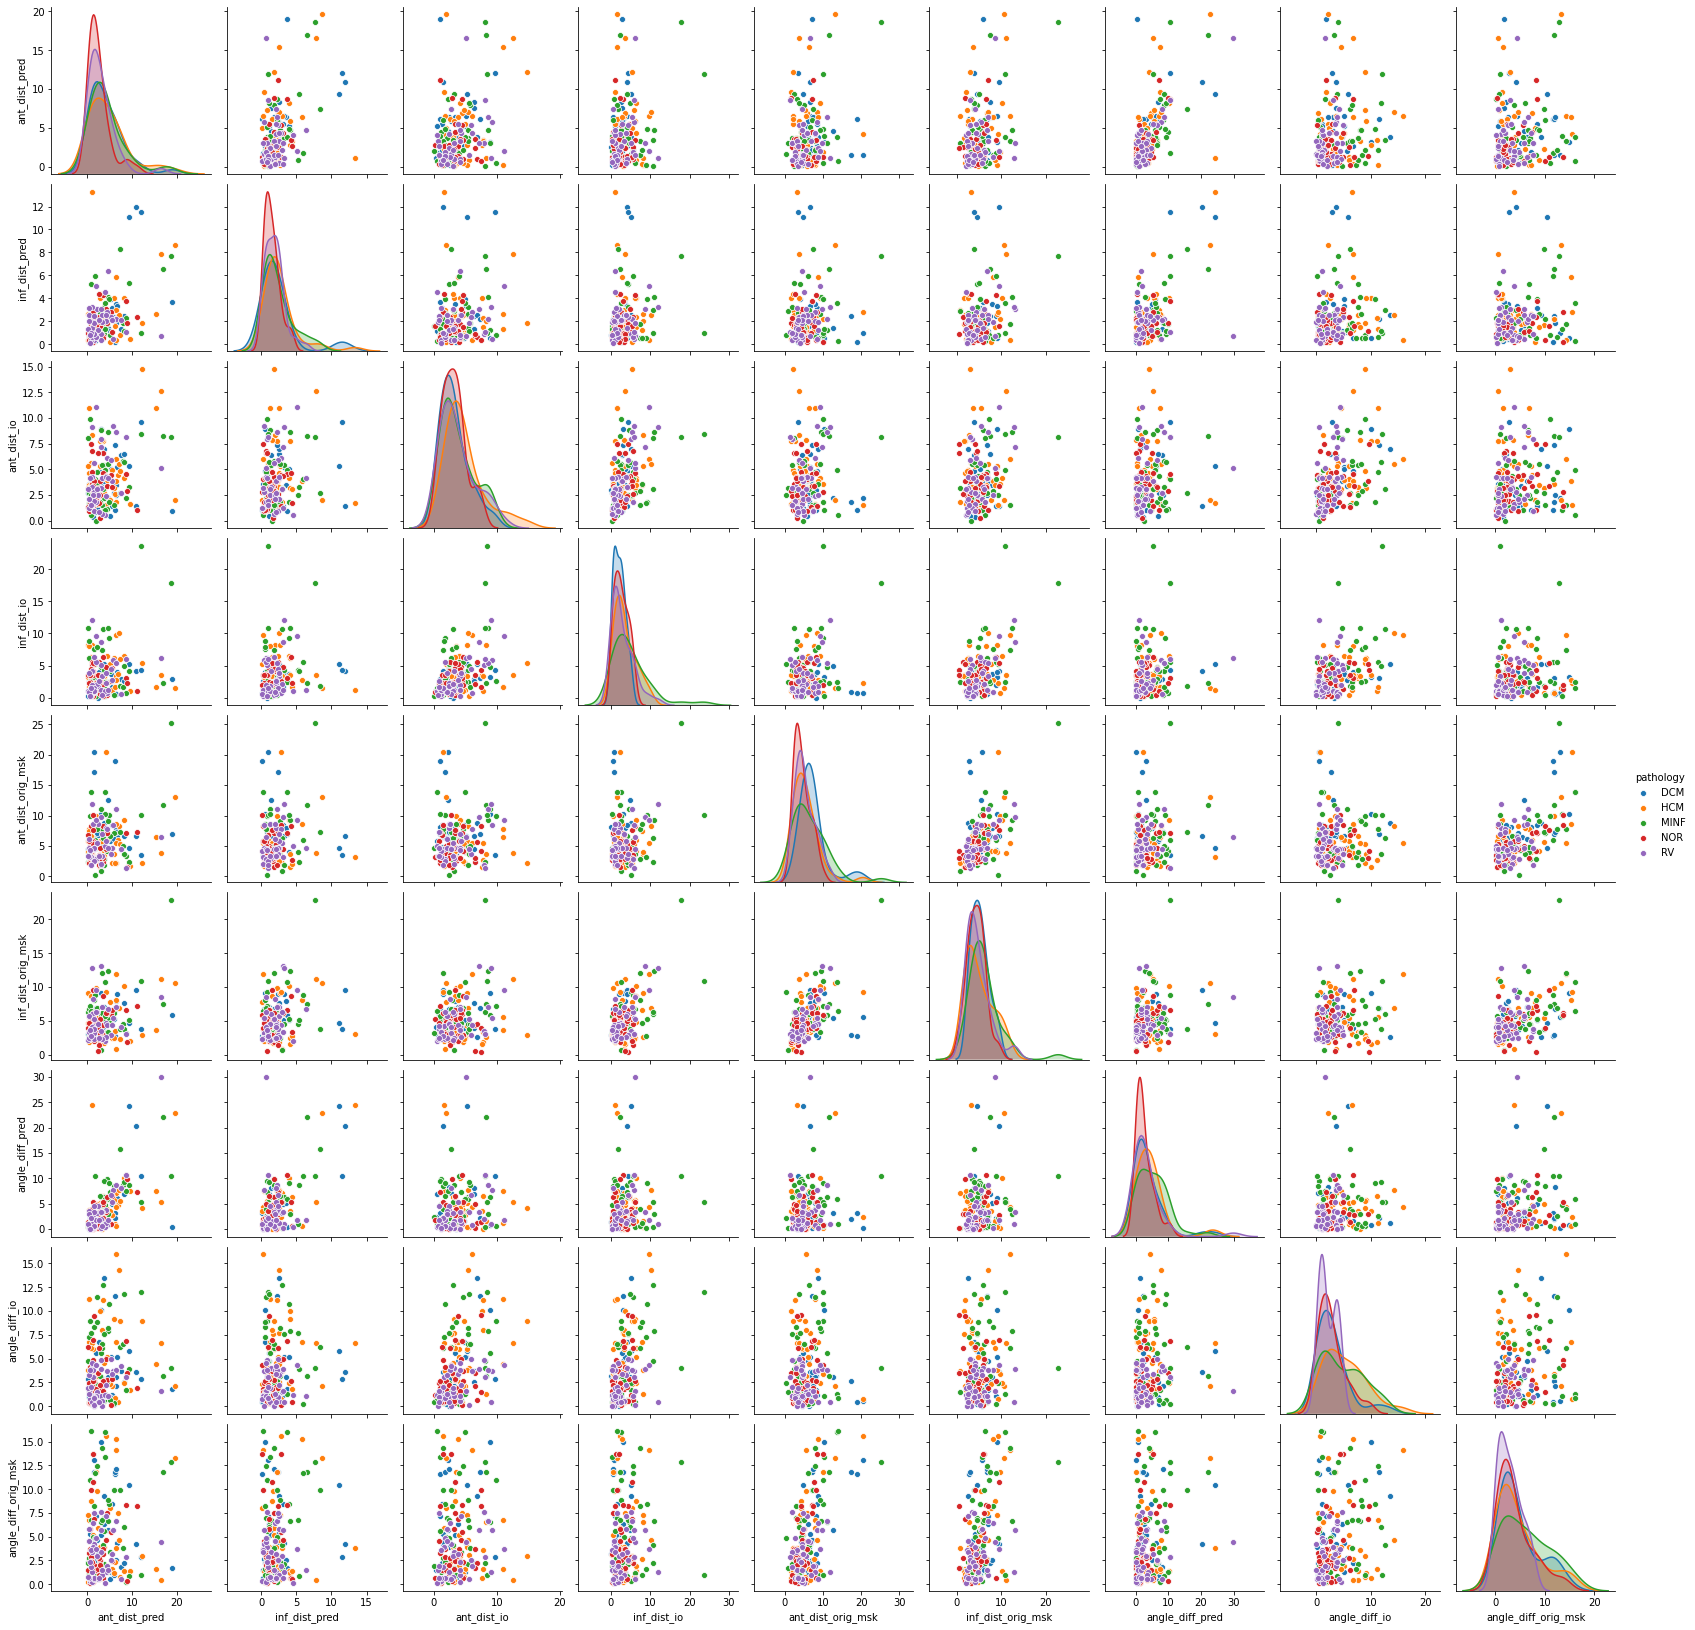

In [43]:
cols = ['ant_dist_pred','inf_dist_pred','ant_dist_io','inf_dist_io','ant_dist_orig_msk', 'inf_dist_orig_msk', 'angle_diff_pred', 'angle_diff_io', 'angle_diff_orig_msk', 'pathology']
sb.pairplot(data = df_eval[cols], hue='pathology')

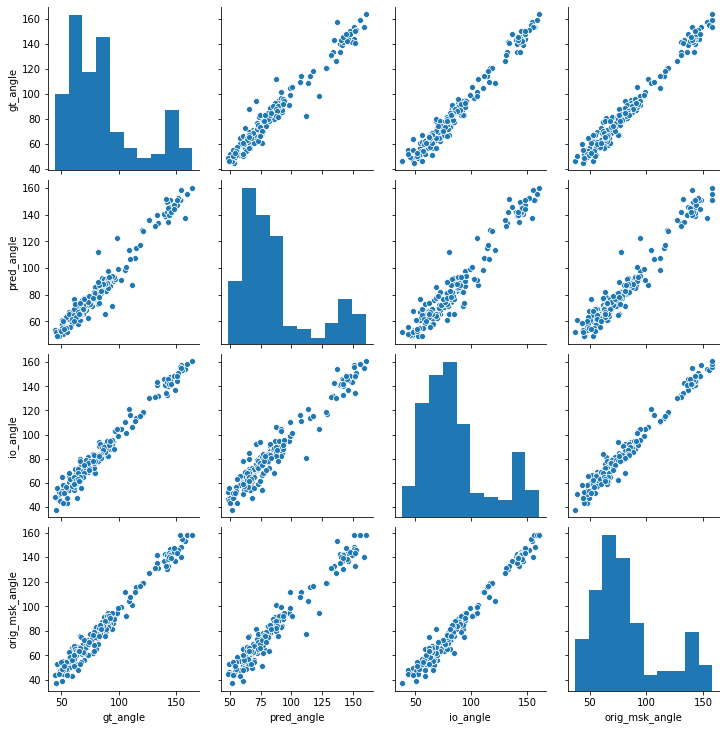

In [50]:
cols = ['gt_angle','pred_angle','io_angle','orig_msk_angle']
sb.pairplot(data =df_eval[cols])

In [25]:
# filter the df_angles dataframe by specific values
@interact
def inspect_angle_df_interact(greater_as='0', col=df_angles.columns):
    greater_as = float(greater_as)
    df_filter = df_eval[df_eval[col]>=greater_as]
    print(df_filter[['patient','phase']])
    return df_filter

interactive(children=(Text(value='0', description='greater_as'), Dropdown(description='col', options=('angle_d…

/home/sven/anaconda3/envs/septum_detection/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: Mean of empty slice


<AxesSubplot:>

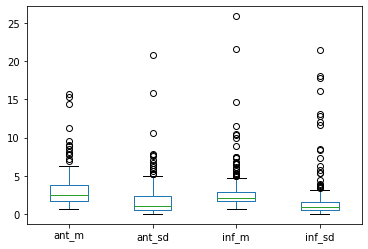

In [18]:
# calc the distances for all pred_files
df_dist = pd.DataFrame(columns=['ant_m', 'ant_sd', 'inf_m', 'inf_sd'])
for i in range(len(gt_files)):
    to_append = calc_dist_files(gt_files[i], pred_files[i],physical=True)
    a_series = pd.Series(to_append, index = df_dist.columns)
    df_dist = df_dist.append(a_series, ignore_index=True)
df_dist.plot(kind='box')

/home/sven/anaconda3/envs/septum_detection/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: Mean of empty slice
/home/sven/anaconda3/envs/septum_detection/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<AxesSubplot:>

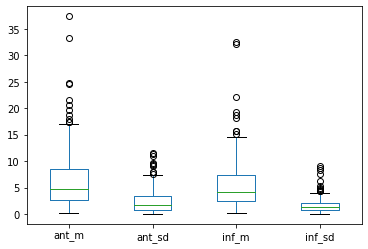

In [19]:
# calc the distances for all io files
df_dist = pd.DataFrame(columns=['ant_m', 'ant_sd', 'inf_m', 'inf_sd'])
for i in range(len(gt_files)):
    try:
        to_append = calc_dist_files(gt_files[i], io_files[i],physical=True)
    except AssertionError as e:
        print(e)
        print(gt_files[i])
        print(io_files[i])
    a_series = pd.Series(to_append, index = df_dist.columns)
    df_dist = df_dist.append(a_series, ignore_index=True)
df_dist.plot(kind='box')